# Interpretability of Multi-Output Classifier(Water Quality Dataset)

In [1]:
from IPython.display import display, HTML, Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn import metrics

# to avoid future warnings for sklearn
import warnings
warnings.filterwarnings("ignore")

In [2]:
import eli5
from eli5.sklearn import PermutationImportance

import lime
import lime.lime_tabular
from __future__ import print_function
np.random.seed(1)

# Load ML Interpreting Models
import shap
# Initialize JS For Plot
shap.initjs()

In [3]:
# Read the CSV file
dataset = pd.read_csv('water-quality.csv')
print("Dataset.shape: " + str(dataset.shape))

# split the features-X and class labels-y
X = dataset.iloc[:, :-14]
y = dataset.iloc[:, -14:]

print("X.shape: " + str(X.shape))
display(X.head())
print("y.shape: " + str(y.shape))
display(y.head())
print("Descriptive stats:")
X.describe()

Dataset.shape: (1060, 30)
X.shape: (1060, 16)


std_temp     std_pH   conduct        o2     o2sat       co2  hardness  \
0  0.662303  23.722053  2.973241  5.343706  4.446809  0.000000  3.546433   
1  2.025867  23.722053  3.298439  4.100984  4.072903  0.155396  3.388814   
2  3.253074  23.421773  2.740956  3.645319  4.157477  0.699283  2.955361   
3  3.759541  24.022332  2.657334  3.231078  3.877047  0.000000  3.034170   
4  1.928469  23.121494  2.332136  4.515224  4.429004  0.699283  3.112980   

        no2       no3       nh4       po4        cl      sio2     kmno4  \
0  0.403047  2.362222  0.232044  0.189460  1.459533  1.663324  1.026990   
1  0.345469  2.178153  0.210949  0.526279  1.739018  2.217765  0.837808   
2  0.460625  3.098499  0.097036  0.315767  0.776347  3.188038  0.851321   
3  6.966957  1.932727  0.147664  0.210512  0.817753  2.633596  0.918886   
4  0.633360  2.147475  0.189854  0.357870  1.076535  2.598944  0.851321   

    k2cr2o7       bod  
0  0.841600  0.203596  
1  0.712491  0.150484  
2  0.707709  0.247856  
3  0.736400  0.416043  
4  0.827255  0.345227

y.shape: (1060, 14)


Label1  Label2  Label3  Label4  Label5  Label6  Label7  Label8  Label9  \
0       1       0       0       0       0       1       1       0       1   
1       0       1       0       1       1       1       1       0       1   
2       1       1       0       0       1       0       1       0       1   
3       1       1       0       0       1       1       1       1       1   
4       0       0       1       0       0       1       0       0       1   

   Label10  Label11  Label12  Label13  Label14  
0        1        1        1        1        1  
1        1        1        1        1        0  
2        1        1        0        1        1  
3        1        1        1        0        0  
4        0        0        1        0        1

Descriptive stats:


std_temp       std_pH      conduct           o2        o2sat  \
count  1060.000000  1060.000000  1060.000000  1060.000000  1060.000000   
mean      2.464376    24.170205     3.073956     4.370396     4.509492   
std       1.059541     0.966318     1.037480     1.045264     1.024500   
min       0.058438    21.019540     0.966303     0.041424     0.048964   
25%       1.636277    23.421773     2.406467     3.893863     4.141897   
50%       2.405717    24.322611     2.950012     4.473800     4.553639   
75%       3.233595    24.923169     3.560921     4.970889     4.976508   
max       5.356859    27.925961    12.422572     8.491936    10.580645   

               co2     hardness          no2          no3          nh4  \
count  1060.000000  1060.000000  1060.000000  1060.000000  1060.000000   
mean      0.397726     4.034421     0.463015     1.569769     0.265489   
std       1.009108     1.054268     0.957149     1.052141     0.872142   
min       0.000000     1.694407     0.000000     0.000000     0.012657   
25%       0.000000     3.349409     0.057578     0.920346     0.046409   
50%       0.000000     3.940481     0.172734     1.395858     0.084379   
75%       0.427340     4.689172     0.403047     2.055440     0.147664   
max       9.556867     9.930012     8.751880    18.805741    17.086844   

               po4           cl         sio2        kmno4      k2cr2o7  \
count  1060.000000  1060.000000  1060.000000  1060.000000  1060.000000   
mean      0.294657     0.603969     1.223007     0.581876     0.544428   
std       0.743339     0.643723     0.956059     0.875774     0.750472   
min       0.000000     0.062108     0.069305     0.013513     0.062164   
25%       0.042102     0.238080     0.554441     0.256748     0.205618   
50%       0.105256     0.372647     0.970272     0.351339     0.349073   
75%       0.273665     0.745294     1.559366     0.624978     0.635982   
max      12.314930     6.562724     6.618643    19.107427    14.967098   

               bod  
count  1060.000000  
mean      0.349620  
std       0.544120  
min       0.017704  
25%       0.115076  
50%       0.185892  
75%       0.354079  
max       7.081589

In [4]:
# Normalise the data
X = (X-X.min())/(X.max()-X.min())

from sklearn.model_selection import train_test_split
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

print("X_train.shape: " + str(X_train.shape))
print("X_test.shape: " + str(X_test.shape))
print("y_train.shape: " + str(y_train.shape))
print("y_test.shape: " + str(y_test.shape))

X_train.shape: (742, 16)
X_test.shape: (318, 16)
y_train.shape: (742, 14)
y_test.shape: (318, 14)


In [5]:
from sklearn.multioutput import MultiOutputClassifier

MO_classifier = MultiOutputClassifier(RandomForestClassifier(criterion='entropy'), n_jobs=-1)

MO_pred = MO_classifier.fit(X_train, y_train).predict(X_test)


In [6]:
MO_pred_df=pd.DataFrame(MO_pred, columns=y.columns.tolist())

In [7]:
MO_pred_df

Label1  Label2  Label3  Label4  Label5  Label6  Label7  Label8  Label9  \
0         0       0       0       0       0       0       0       0       1   
1         0       0       1       0       0       0       0       0       0   
2         0       0       0       0       0       0       0       0       0   
3         0       1       0       0       0       1       0       1       1   
4         1       0       0       0       0       0       0       0       1   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
313       0       0       0       0       0       0       0       0       1   
314       0       0       0       0       1       1       0       0       1   
315       1       0       1       0       1       1       0       1       1   
316       1       0       0       0       0       1       0       0       0   
317       1       0       1       0       0       0       0       1       0   

     Label10  Label11  Label12  Label13  Label14  
0          0        0        1        0        0  
1          0        0        1        0        0  
2          0        0        1        0        0  
3          0        0        0        0        0  
4          0        1        0        0        0  
..       ...      ...      ...      ...      ...  
313        0        0        1        0        0  
314        0        0        0        0        0  
315        0        1        0        0        0  
316        0        0        0        0        1  
317        0        0        0        0        0  

[318 rows x 14 columns]

In [8]:
MO_classifier.predict_proba(X_test)

[array([[1.  , 0.  ],
        [0.74, 0.26],
        [0.86, 0.14],
        [0.77, 0.23],
        [0.36, 0.64],
        [0.75, 0.25],
        [0.75, 0.25],
        [0.41, 0.59],
        [0.8 , 0.2 ],
        [0.43, 0.57],
        [0.33, 0.67],
        [0.84, 0.16],
        [0.84, 0.16],
        [0.81, 0.19],
        [0.36, 0.64],
        [0.36, 0.64],
        [0.24, 0.76],
        [0.3 , 0.7 ],
        [0.56, 0.44],
        [0.6 , 0.4 ],
        [0.51, 0.49],
        [0.57, 0.43],
        [0.45, 0.55],
        [0.42, 0.58],
        [0.34, 0.66],
        [0.47, 0.53],
        [0.76, 0.24],
        [0.59, 0.41],
        [0.32, 0.68],
        [0.61, 0.39],
        [0.48, 0.52],
        [0.66, 0.34],
        [0.79, 0.21],
        [0.63, 0.37],
        [0.5 , 0.5 ],
        [0.18, 0.82],
        [0.41, 0.59],
        [0.61, 0.39],
        [0.87, 0.13],
        [0.52, 0.48],
        [0.16, 0.84],
        [0.47, 0.53],
        [0.49, 0.51],
        [0.8 , 0.2 ],
        [0.38, 0.62],
        [0

In [9]:
print(type(MO_classifier.predict_proba(X_test)))

<class 'list'>


In [8]:
# calculate multioutput precision and loss
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss

avg_precision = label_ranking_average_precision_score(y_test, MO_pred)
loss = label_ranking_loss(y_test, MO_pred)

print('Average precision {0:.5f} and loss {1:.5f}'.format(avg_precision, loss))

Average precision 0.53656 and loss 0.57317


If we want the prediction result to be a certain prediction label directly, we use the prediction function.

If we want the prediction result to be the probability of the label, use the predict_proba function.

# Explain With SHAP

### SHAP does not support predict_proba function of this classifier.

In [11]:
explainer_MO = shap.KernelExplainer(MO_classifier.predict_proba,X_train)

AttributeError: 'list' object has no attribute 'shape'

### So we explain the predict function of this classifier.

In [13]:
explainer_MO = shap.KernelExplainer(MO_classifier.predict,X_train)

Using 742 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Local Interpretability

### Explanation of Sample 1 for Label 1

In [14]:
shap_values = explainer_MO.shap_values(X_test.iloc[0,:])
shap.force_plot(explainer_MO.expected_value[0], shap_values[0], X_test.iloc[0,:])

### Explanation of Sample 1 for Label 2

In [15]:
shap.force_plot(explainer_MO.expected_value[1], shap_values[1], X_test.iloc[0,:])

### Explanation of Sample 1 for Label 3

In [16]:
shap.force_plot(explainer_MO.expected_value[2], shap_values[2], X_test.iloc[0,:])

### Explanation of Sample 1 for Label 4

In [17]:
shap.force_plot(explainer_MO.expected_value[3], shap_values[3], X_test.iloc[0,:])

### Explanation of Sample 1 for Label 5

In [18]:
shap.force_plot(explainer_MO.expected_value[4], shap_values[4], X_test.iloc[0,:])

### Explanation of Sample 2 for Label 1

In [25]:
shap_values = explainer_MO.shap_values(X_test.iloc[1,:])
shap.force_plot(explainer_MO.expected_value[0], shap_values[0], X_test.iloc[1,:])

### Explanation of Sample 2 for Label 2

In [26]:
shap.force_plot(explainer_MO.expected_value[1], shap_values[1], X_test.iloc[1,:])

### Explanation of Sample 2 for Label 3

In [27]:
shap.force_plot(explainer_MO.expected_value[2], shap_values[2], X_test.iloc[1,:])

### Explanation of Sample 2 for Label 4

In [28]:
shap.force_plot(explainer_MO.expected_value[3], shap_values[3], X_test.iloc[1,:])

### Explanation of Sample 2 for Label 5

In [29]:
shap.force_plot(explainer_MO.expected_value[4], shap_values[4], X_test.iloc[1,:])

## Global Interpretability

### Use the K-Means Algorithm to summarize the data otherwise it wil take too much time (a few hours)to complete all the calculation. But on the other hand we will lose some accuracy.

In [30]:
# using kmeans
X_train_summary = shap.kmeans(X_train, 10)
explainer_MO = shap.KernelExplainer(MO_classifier.predict, X_train_summary)
shap_values_KNN_test = explainer_MO.shap_values(X_test)

### Summerize the explanations of predictions about Label 1

In [31]:
shap.force_plot(explainer_MO.expected_value[0], shap_values_KNN_test[0], X_test)

### Summerize the explanations of predictions about Label 2

In [32]:
shap.force_plot(explainer_MO.expected_value[1], shap_values_KNN_test[1], X_test)

### Summerize the explanations of predictions about Label 3

In [34]:
shap.force_plot(explainer_MO.expected_value[2], shap_values_KNN_test[2], X_test)

### Summerize the explanations of predictions about Label 4

In [36]:
shap.force_plot(explainer_MO.expected_value[3], shap_values_KNN_test[3], X_test)

### Summerize the explanations of predictions about Label 5

In [38]:
shap.force_plot(explainer_MO.expected_value[4], shap_values_KNN_test[4], X_test)

## Bar chart of feature Importance

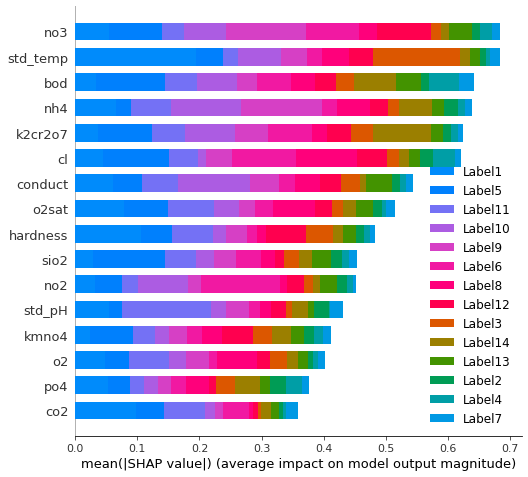

In [42]:
shap.summary_plot(shap_values_KNN_test, X, plot_type="bar",class_names = y.columns.tolist())

## Summarize the impact of all features over the entire dataset

### How each feature impacts Label 1.

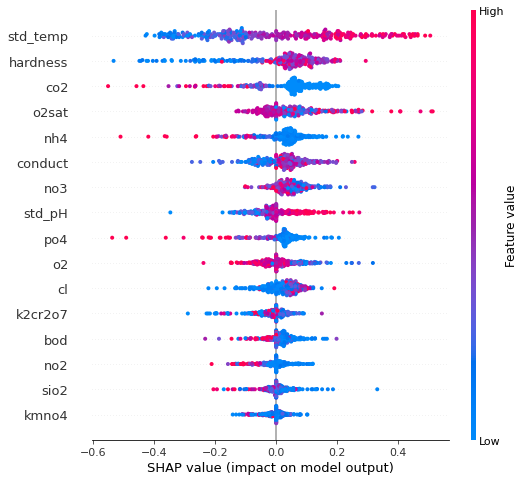

In [43]:
shap.summary_plot(shap_values_KNN_test[0], X_test)

### How each feature impacts Label 2.

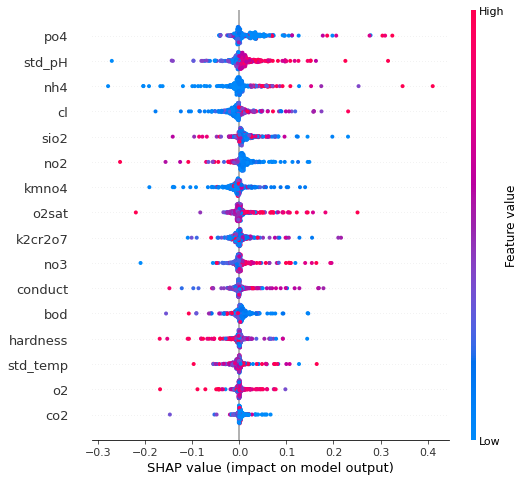

In [45]:
shap.summary_plot(shap_values_KNN_test[1], X_test)

### How each feature impacts Label 3.

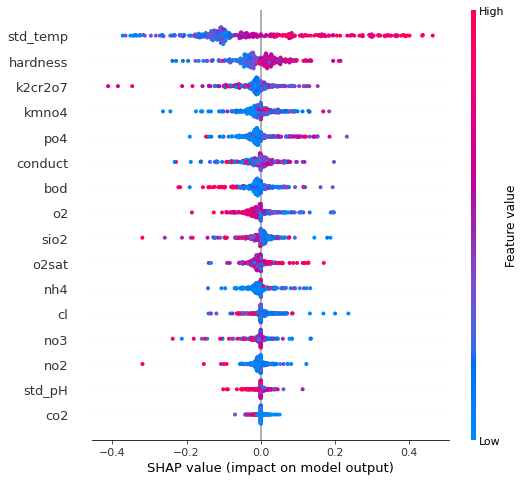

In [47]:
shap.summary_plot(shap_values_KNN_test[2], X_test)

### How each feature impacts Label 4.

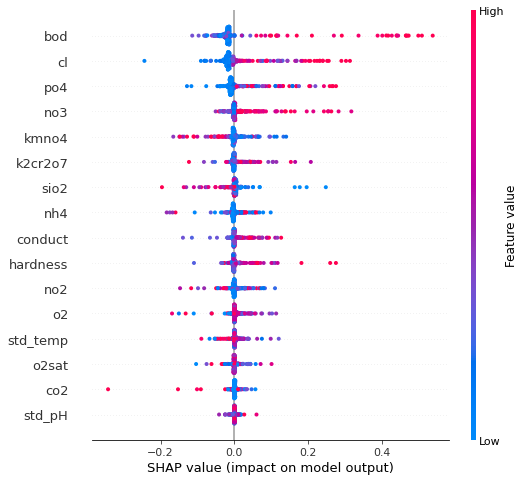

In [49]:
shap.summary_plot(shap_values_KNN_test[3], X_test)

### How each feature impacts Label 5.

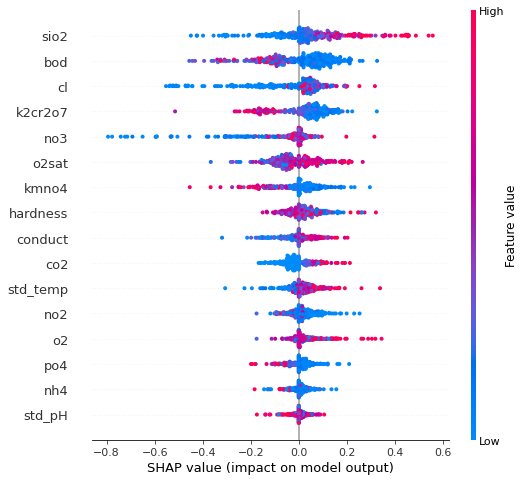

In [50]:
shap.summary_plot(shap_values_KNN_test[4], X_test)

#### From the bar chart of feature importance we know that no3, std_temp, bod, nh4...have the most influences on predictions. So I pick them as example of this part.

## Feature "no3" on Label 1

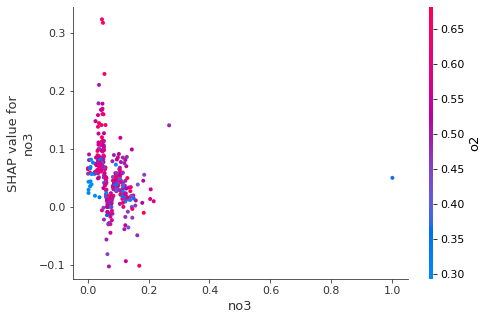

In [51]:
shap.dependence_plot("no3", shap_values_KNN_test[0], X_test)

## Feature "no3" on Label 9

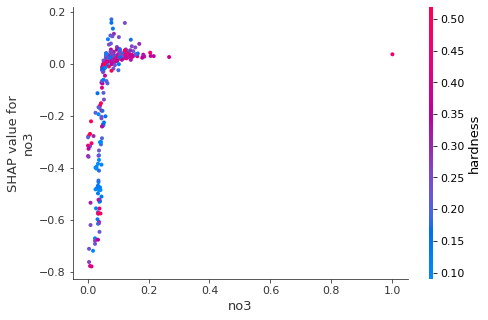

In [52]:
shap.dependence_plot("no3", shap_values_KNN_test[8], X_test)

## Feature "no3" on Label 5

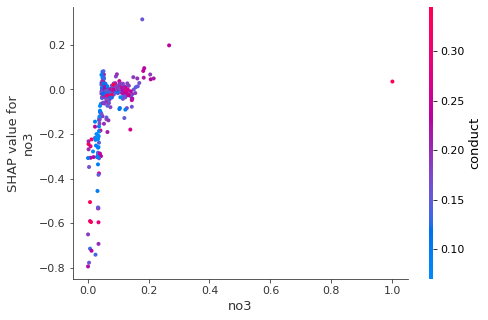

In [53]:
shap.dependence_plot("no3", shap_values_KNN_test[4], X_test)

## Feature "no3" on Label 7

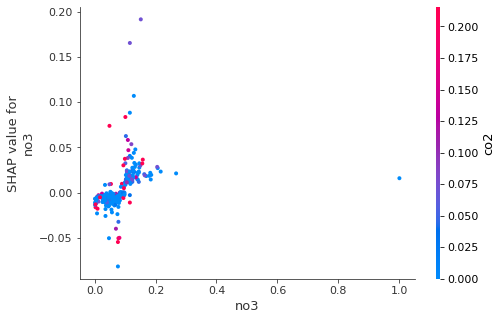

In [55]:
shap.dependence_plot("no3", shap_values_KNN_test[6], X_test)

## Feature "std_temp" on Label 5

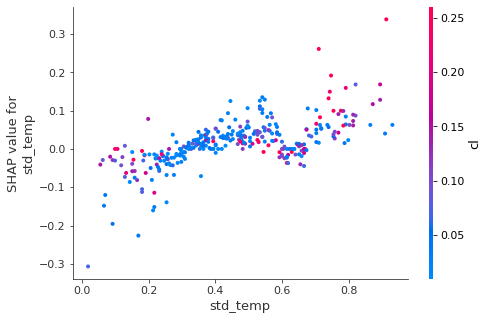

In [57]:
shap.dependence_plot("std_temp", shap_values_KNN_test[4], X_test)

## Feature "std_temp" on Label 3

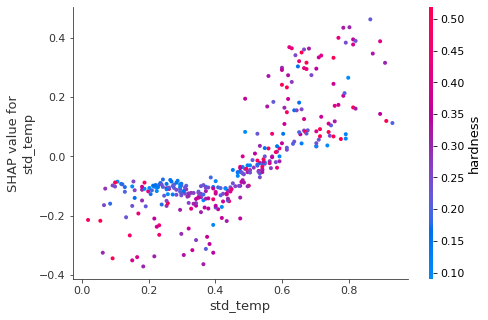

In [58]:
shap.dependence_plot("std_temp", shap_values_KNN_test[2], X_test)

## Feature "std_temp" on Label 1

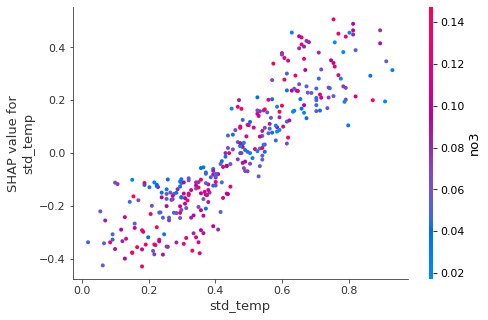

In [60]:
shap.dependence_plot("std_temp", shap_values_KNN_test[0], X_test)

## Feature "bod" on Label 5

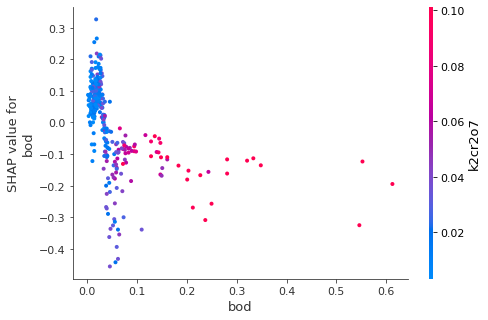

In [61]:
shap.dependence_plot("bod", shap_values_KNN_test[4], X_test)

## Feature "bod" on Label 11

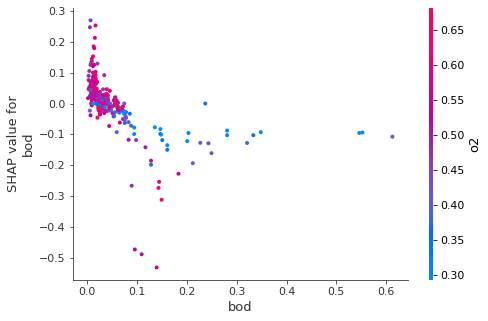

In [62]:
shap.dependence_plot("bod", shap_values_KNN_test[10], X_test)

## Feature "bod" on Label 10

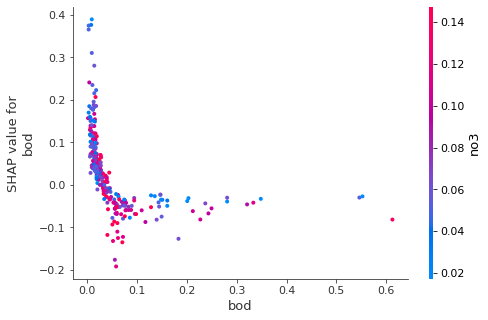

In [63]:
shap.dependence_plot("bod", shap_values_KNN_test[9], X_test)

# Explain with LIME

In [64]:
# Creating the Lime Explainer
# Be very careful in setting the order of the class names
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    training_labels=y_train.values,
    feature_names=X_train.columns.tolist(),
    feature_selection="lasso_path",
    class_names=["Label1","Label2","Label3","Label4","Label5","Label6","Label7","Label8","Label9","Label10","Label11","Label12","Label13","Label14"],
    discretize_continuous=True,
    discretizer="entropy",
)
#Now let's pick a sample case from our test set.
row = 1

## LIME dose not support predict_proba function of this classifier.

In [65]:
exp = lime_explainer.explain_instance(X_test.iloc[row], MO_classifier.predict_proba, num_features=16)
exp.show_in_notebook(show_table=True)

AttributeError: 'list' object has no attribute 'shape'

## So we try predict function.

In [66]:
exp = lime_explainer.explain_instance(X_test.iloc[row], MO_classifier.predict, num_features=16)
exp.show_in_notebook(show_table=True)

In [67]:
row = 15
exp = lime_explainer.explain_instance(X_test.iloc[row], MO_classifier.predict, num_features=16)
exp.show_in_notebook(show_table=True)

In [68]:
row = 150
exp = lime_explainer.explain_instance(X_test.iloc[row], MO_classifier.predict, num_features=10)
exp.show_in_notebook(show_table=True)

### The output above is kind of weird...I still try to figure out the reason.

# Explain with eli5(Permutation Feature Importance)

In [69]:
perms_MO = PermutationImportance(MO_classifier).fit(X_test, y_test)

In [70]:
eli5.show_weights(perms_MO,top=16,feature_names = X.columns.tolist())